# Basic U-Net


## Description

**Kaggle mean Intersection over Union** : 0.43

**Local test mean Intersection over Union**: 0.44

**Description**: The first implementation using a the U-net explained during lesson. No augmentation, no particular optimization, no complex architectures, just a simple U-Net.

**Motivation**: Create a baseline for further improvements

## Google Drive - Connecting to the project

In [71]:
from google.colab import drive
import sys
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 2"
%cd {project_path}
sys.path.append(project_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1CRSDpvo8yN6Wc7UchdjWSs6h8RroV7e4/le acque del friuli - Homework 2


## Imports

In [72]:
%load_ext autoreload
%autoreload 2

# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

from datetime import datetime
from tensorflow.keras.metrics import MeanIoU

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [73]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 21

# Set maximum number of training epochs
EPOCHS = 1000

# Number of classes
NUM_CLASSES = 5

## Load Data

In [74]:
# Load the dataset
data = np.load("dataset/cleaned_dataset.npz")
test_img = data['test_set']

# Split the dataset in images and labels array
X = data['images']
y = data['labels']

# Split the dataset into training, test, and validation
train_img, test_img_local, train_lbl, test_lbl_local = train_test_split(X, y, test_size=0.2, random_state=seed)
train_img, val_img, train_lbl, val_lbl = train_test_split(train_img, train_lbl, test_size=0.2, random_state=seed)

In [75]:
# Function to create a dataset with batch and shuffle
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    # Shuffle the dataset if requested
    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [76]:
# Create the training dataset
train_dataset = make_dataset(train_img, train_lbl, batch_size=BATCH_SIZE, shuffle=True, augment=True, seed=seed)

# Create the validation dataset
val_dataset = make_dataset(val_img, val_lbl, batch_size=BATCH_SIZE, shuffle=False, augment=False, seed=seed)

## Utils

In [77]:
# Define custom Mean Intersection over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        self.labels_to_exclude = [0]

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [78]:
# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image = image
        self.label = label
        self.frequency = frequency
        self.colormap = plt.cm.viridis(np.linspace(0, 1, 5))

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image = tf.expand_dims(self.image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = self.colormap[self.label.astype(int)]
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = self.colormap[y_pred[0].astype(int)]
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()


## Model Implementation

In [79]:
# Definition of a U-net block
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    return x

In [80]:
# Definition of the model
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [81]:
# Model contruction
model = get_unet_model()

# Print a detailed summary of the model
model.summary(expand_nested=True, show_trainable=True)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_6        │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d_6[0]… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 473,669 (1.81 MB)

 Trainable params: 472,389 (1.80 MB)

 Non-trainable params: 1,280 (5.00 KB)

## Training

In [84]:
# Model compilation with Adam as optimizer and sparse categorical crossentropy as loss function
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    metrics=["accuracy"]
)

In [85]:
# Implementation of early stopping as a technique to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)
viz_callback = VizCallback(val_img[111], val_lbl[111],frequency=2)

In [86]:
# Actual training of the model with the given parameters
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping],
    verbose=1,
).history

Epoch 1/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 314ms/step - accuracy: 0.3377 - loss: 1.5582 - val_accuracy: 0.0373 - val_loss: 14.6355
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5535 - loss: 1.1619 - val_accuracy: 0.2000 - val_loss: 7.0146
Epoch 3/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5889 - loss: 1.0585 - val_accuracy: 0.4121 - val_loss: 1.3701
Epoch 4/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.6222 - loss: 0.9827 - val_accuracy: 0.3978 - val_loss: 1.6640
Epoch 5/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.6331 - loss: 0.9461 - val_accuracy: 0.5026 - val_loss: 1.2991
Epoch 6/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.6546 - loss: 0.8909 - val_accuracy: 0.4865 - val_loss: 1.2292
Epoch 7/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.6650 - loss: 0.8651 - val_accuracy: 0.5867 - val_loss: 1.0935
Epoch 8/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.6746 - loss: 0.8429 - val_a

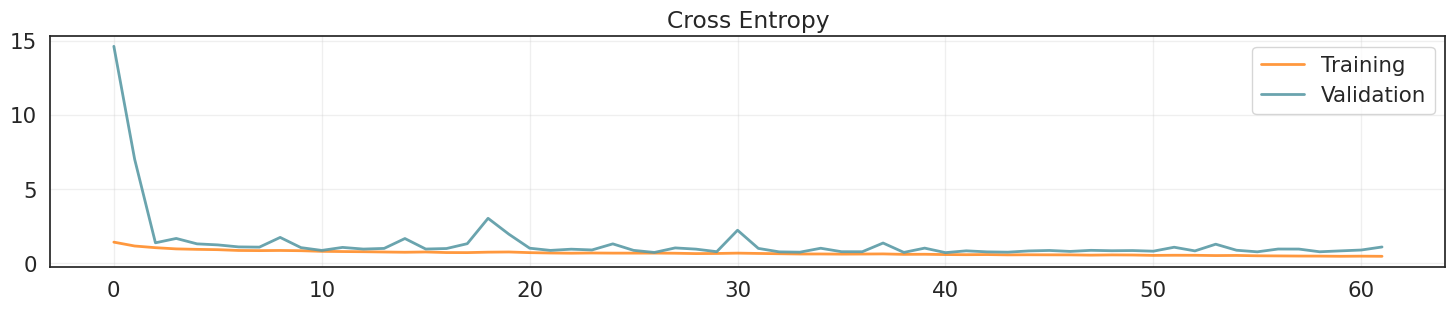

In [87]:
# Plot the loss function value over epochs
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Test Prediction and Final Evaluation

In [88]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(test_img_local, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)

In [90]:
# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_lbl_local.flatten(), test_predictions.flatten())
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_lbl_local.flatten(), test_predictions.flatten(), average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(test_lbl_local.flatten(), test_predictions.flatten(), average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(test_lbl_local.flatten(), test_predictions.flatten(), average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Calculate and display test set mean Intersection Over Union score
one_hot_pred = tfk.utils.to_categorical(test_predictions, num_classes=NUM_CLASSES)
test_miou = MeanIntersectionOverUnion(NUM_CLASSES)
test_miou.update_state(test_lbl_local, one_hot_pred)
test_miou = test_miou.result().numpy()
print(f'Mean Intersection over Union over the test set: {round(test_miou, 4)}')

Accuracy score over the test set: 0.7249


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision score over the test set: 0.7225
Recall score over the test set: 0.7249
F1 score over the test set: 0.7188
Mean Intersection over Union over the test set: 0.4404999911785126


## Save

In [91]:
# Saving the model for testing and submission
current_time = datetime.now().strftime("%d|%m-%H:%M")
model_filename = f'UNet_{current_time}.keras'
print("Saved as :",model_filename)
model.save(f'models/{model_filename}', include_optimizer=False)

Saved as : UNet_14|12-11:24.keras


## Submission

In [92]:
# Predict the masks for the submission
preds = model.predict(test_img)
preds = np.argmax(preds, axis=-1)

314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Predictions shape: (10022, 64, 128)


In [93]:
# Converts segmentation predictions into a DataFrame format for Kaggle
def y_to_df(y) -> pd.DataFrame:
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [94]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submissions/submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)